# Fragile Families Challenge

Across the social sciences, researchers are increasingly using techniques from machine learning (ML) to tackle policy-relevant questions and gain new insights into social phenomena (Kleinberg et al. 2015; Molina and Garip 2019; Mullainathan and Spiess 2017). A seminal example of this is the Fragile Families Challenge (FFC): a predictive modelling challenge which charged participants with predicting six outcomes for 4,242 children and their families (Salganik et al., 2020). To date, more than 160 researchers/teams have taken part in the FFC, using a variety of different methods and predictive models (Salganik et al., 2020). In this paper, I leverage insights from this extant literature to partake in the FFC and make predictions on the holdout test data for each of the six target variables. Building on this, I investigate which features were most important for making the models’ predictions.

## Background: About the FFC

The Fragile Families Challenge (FFC) was a predictive modelling challenge which charged partic- ipants with predicting six outcomes for 4,242 children and their families who were interviewed in the Fragile Families and Child Wellbeing Study (FFCWS) (Reichman et al. 2001; Salganik et al. 2020). The FFCWS is an ongoing study that collects rich longitudinal data about thousands of families, each of whom gave birth to a child in a large US city around the year 2000 (Reichman et al., 2001). The study was designed to understand families formed by unmarried parents and the lives of children born into these families.
The Fragile Families data - which have been used in more than 750 published journal articles (Sal- ganik et al., 2020) - were collected in six waves: birth, and ages 1, 3, 5, 9 and 15. Each wave includes a number of different data collection modules, ranging from surveys to in-home assess- ments/observations made by the researchers (Figure 1).

![Figure 1: FFC Overview](https://drive.google.com/file/d/1BUTkSF8ZY-RjSJg09Hmtj0w5IPFCYOFn/view?usp=sharing)

In the FFC, participants were tasked with creating predictive models for six outcome variables at age 15:
1. gpa: Grade Point Average (GPA) outcomes are a measure of academic achievement and were obtained by averaging the child’s self-reported GPA across four subjects at age 15: English, mathematics, social sciences, and natural sciences (Lundberg, 2017c). Values range from 1 to 4.
2. grit: Grit is a difficult concept to measure (Schmidt et al., 2017), but in the FFC it was measured on a scale of 1 to 4 based on answers given by the children to four questions at age 15 (Lundberg, 2017d).
3. materialHardship: The material hardship variable was included as a measure of poverty. Its values range from 0 to 1, and represent the proportion of times a respondent answered ”Yes” to 11 questions about their material circumstances Lundberg (2017a).
4. eviction: The eviction outcome is a categorical variable marked true if the child’s primary caregiver had been evicted from their home at any point since the child was 9 (Lundberg, 2017b).
5. layoff : The layoff outcome is a categorical variable marked true if the child’s primary caregiver had been evicted from their home at any point since the child was 9 (Lundberg, 2017f).
6. jobTraining: When each child was 15, their primary caregiver was asked whether they had undertaken any classes to improve their job skills. The jobTraining outcome is marked true if they answered yes (Lundberg, 2017e).

To build their predictive models, participants were given access to the data collected from birth to age 9 (a total of 12,942 variables about each family).

## Import libraries

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
google_drive_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
import re
from collections import Counter
import random

import sklearn
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer, quantile_transform, 
StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error, 
f1_score, roc_auc_score, classification_report, brier_score_loss
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.model_selection import train_test_split, GridSearchCV, 
RandomizedSearchCV
from sklearn.feature_extraction import _stop_words
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, 
mutual_info_classif, mutual_info_regression
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor, XGBClassifier

import shap
shap.initjs()

from skopt import BayesSearchCV

import nltk, string
from nltk import edit_distance
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Load the data

In [ ]:
data_dir = Path.cwd()/'data'

# background.csv contains 4,242 rows (one per family) and 13,027 columns
#                index by challengeID: A unique numeric identifier for each child.
#                features: 13,026 background variables asked from birth to age 9, 
#                which you may use in building your model.
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore the DtypeWarning
    background = pd.read_csv(f'{data_dir}/FFChallenge_v5/background.csv', sep=',', 
                             header=0,index_col=0)

# train.csv contains 2,121 rows (one per child in the training set) and 7 columns
train = pd.read_csv(f'{data_dir}/FFChallenge_v5/train.csv', sep=',', header=0, 
                    index_col=0)

# constantVariables.txt gives the column names of variables that are constant 
# in the data
constantVariables = pd.read_csv(f'{data_dir}/FFChallenge_v5/constantVariables.txt',
                                header=None, index_col=0)

# Load test/evaluation data
test = pd.read_csv('test.csv', index_col='challengeID')

## Data pre-processing

Before I could address these research aims, I first needed to preprocess the data. As Kuhn and Johnson (2013: 27) pithily put it, “data preparation can make or break a model’s predictive ability”. To preprocess the data, I began by taking two steps. First, I converted data types: values which could be cast as numeric values were converted from text into those numeric values, and categorical variables were converted into integer representations where possible. These transformations were performed because the models I used all require numerical inputs. Features that could not be converted - 115 in total - were removed, which is justified on the basis that most these features were constructed variables based on data contained in the other features anyway, so it was not anticipated that there would be much information loss by removing them. The second initial preprocessing step was to remove constant columns which contained zero variation in the data; this was justified on the basis that these columns would provide no predictive information. As a result of these two operations, 2,519 features were removed from the data set.

After these initial steps, the background data set was split into three sets: training, leaderboard, and holdout data. This was done to avoid “leakage” and prevent the introduction of information about the target during the training process, which inhibits models’ ability to generalise (Kaufman et al., 2012). To ensure that data were processed consistently, I created a pipeline which sequentially applied four data transformations designed to handle missing values, create new features, standardise the data, and resample.

### Step 1: Drop constant columns

In [ ]:
# Drop constant columns
background = background.drop(constantVariables.index.values, axis = 1)

### Step 2: Drop non-numeric columns

In [ ]:
mixed_cols = background.columns[background.dtypes=='object']

background.loc[:, mixed_cols].dtypes.value_counts()

object    115
dtype: int64

In [ ]:
for col in mixed_cols:
    try: 
        background.loc[:, col] = pd.to_numeric(background.loc[:, col].replace({"Other": np.NaN}))
    except:
        pass

background.loc[:, mixed_cols].dtypes.value_counts()

float64    88
object     27
dtype: int64

In [ ]:
# Drop non-numeric columns
background = background[background.columns[background.dtypes!='object']]

### Step 3: Cross-path imputation

One of the major challenges of the FFC was missing data (Goode et al., 2019). Of the approximately 55 million distinct values, approximately 73% were missing (Figure 3). A simplistic approach to handling missing values is to discard data, either in the form of complete- case analysis (where all observations with a missing value are excluded) or available-case analysis (where different subsets of data are used to tackle different questions). The problem with this approach, however, is that discarding data can yield biased estimates if nonrespondents differ sys- tematically from respondents (Gelman et al. 1995; Emmanuel et al. 2021).

An alternative approach is to “impute” values, using information about why the values are missing to inform the strategy used to perform the imputations (Kuhn et al. ?; Allison 2001; Little and Rubin 1989). In the context of the FFC, researchers have used a variety of techniques to impute missing values, yet these often overlook the fact that many values are missing because of structural reasons to do with the research design and data collection methods (Goode et al., 2019). Most notably, many values are missing as a result of “skip patterns” in the questionnaires used to collect data, which arise because the questions participants are asked depends in part on the answers they give to other questions (Goode et al., 2019). For example, in the survey administered to mothers in Wave 1 (birth), question B2 asks where respondents are married. If they respond “Yes”, the interviewer is instructed to skip straight to question B22, meaning that missing values are recorded for the questions in between. If a respondent answered “No” to B2, however, they would proceed to the next question, which was identical to B22, but then later be asked to skip over B22 given they had already answered a similar question. As a result of these skip patterns, many of the surveys contain the same questions repeated multiple times, with all but one of the answers recorded as missing values because these questions were skipped over.

To handle this type of missing value, I followed a process inspired by Goode et al. (2019), who attempt to impute these missing values using values from “similar” questions which were not skipped. To identify similar questions, Goode et al. calculate the Levenshtein edit distance (Riza et al., 2020) between all question codes, and impute missing values using the mean value from the columns with the most similar question codes.

The problem with Goode et al.’s approach, however, is that it leads to many false positives and provides an unreliable way to identify similar questions. To improve on Goode et al.’s technique, I designed an algorithm which identifies questions from the same survey and wave based on their question code, and then calculates the cosine similarity between the actual questions themselves, using a vectorized representation of the questions. I then manually inspected the results and found no false positives, implying that this method offers a substantial improvement over Goode et al.’s approach. While there is an inherent risk that this imputation strategy may propagate measurement error (Gelman et al., 1995), I deemed this risk to be minimal given that most “skip” questions were non-sensitive, factual questions where there was no obvious incentive for respondents to misrepresent information.


In [ ]:
# E.g. 
background[['m1b5a', 'm1b11a', 'm1b22a']]

,m1b5a,m1b11a,m1b22a
challengeID,,,
1,-6,-6,1
2,-6,2,-6
3,-6,-6,1
4,-6,1,-6
5,-6,1,-6
...,...,...,...
4238,-6,2,-6
4239,-6,1,-6
4240,1,-6,-6


#### 3a: Load questions

In [ ]:
# Extract questions and IDs from codebook
with open(f'{data_dir}/FFChallenge_v5/codebook_FFChallenge.txt', 'r') as filein:
    f = filein.readlines()
    questions = []
    for i, line in enumerate(f[:len(f)-10]):
        if line.startswith('----------------------------------------------------------------------------------------------------------------------------------------------\n'):
            questions.append(f[i+1])
            
    questions = [questions[i][:-1] for i, x in enumerate(questions) if i%2==0]

In [ ]:
# Separate questions and IDs
ids = list()
qs = list()
for i, x in enumerate(questions):
    split = questions[i].split(" ", 1)
    ids.append(split[0])
    qs.append(split[1].strip().lower())
    
# Put into DataFrame for easy visualisation
questions_df = pd.DataFrame({"question": qs}, index=ids)

questions_df

,question
challengeID,(unlabeled)
cf1intmon,father interview month
cf1intyr,father interview year
cf1lenhr,what was the total length of interview - hours
cf1lenmin,what was the total length of interview - minutes
...,...
m5c6,first principal component scale created from m...
m5d20,first principal component scale created from m...
m5k10,first principal component scale created from m...
f5c6,first principal component scale created from f...


#### 3b: Get vectorized representation of each question

In [ ]:
# CountVectorizer
count_vectorizer = CountVectorizer()
corpus = [q for q in questions_df.question]
count_matrix = count_vectorizer.fit_transform(corpus)
count_vect_arr = np.array(count_matrix.todense())
questions_df['count_vec'] = count_vect_arr.tolist()
questions_df

,question,count_vec
challengeID,(unlabeled),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
cf1intmon,father interview month,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
cf1intyr,father interview year,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
cf1lenhr,what was the total length of interview - hours,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
cf1lenmin,what was the total length of interview - minutes,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
m5c6,first principal component scale created from m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
m5d20,first principal component scale created from m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
m5k10,first principal component scale created from m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
f5c6,first principal component scale created from f...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### 3c: Impute missing values based on within-survey lookup

In [ ]:
def findSimilarInSurvey(key, df):
    """
    For a given question key, return a list of questions from the same survey, wave 
    and section.
    """
    # Find columns with similar variable names to the key columns
    r = re.compile('([a-z]+[0-9]+[a-z])')
    m = r.match(key)
    group_key = m.groups()[0] # Extract the q's code (survey, year, section)
    candidates = questions_df.index[questions_df.index.str.startswith(group_key)]
    
    # Some columns have been removed from df in Step 0. Since we are generating candidates
    # from questions_df (where none are removed), we need to remove those that have been
    candidates = [c for c in candidates if c in df.columns] 
    
    # Remove candidates which don't contain 'skip' values and which aren't in background
    pruned_candidates = [c for c in candidates if (c in df.columns) and (-6 in df[c].unique())]
    
    return pruned_candidates

# Test
# findSimilarInSurvey('m1b5a', background) # test

In [ ]:
def getCosineSimilarities(key, candidates, vectors='count_vec'):
    """
    A function that takes a given key and returns the columns from the same section
    (section is e.g. Wave 1, Mother Survey, Section F) which are most similar in 
    terms of the cosine similarity of (vectorized representations of) their two 
    question descriptions.
    """
    questions = list()
    for c in candidates:
        questions.append(questions_df.loc[c]['question'])
    
    # Create array of the key column's description's vectorized representation
    key_arr = np.array(questions_df.loc[key][vectors]).reshape(1, -1)
    
    cosine_sims = list()
    for c in candidates:
        arr2 = np.array(questions_df.loc[c][vectors]).reshape(1, -1)
        cosine_sims.append(cosine_similarity(key_arr, arr2)[0][0])
        
    cosine_sims = sorted(zip(candidates, cosine_sims, questions), 
                         key=lambda x: x[1], 
                         reverse=True)
    
    return cosine_sims

# Test
# candidates = findSimilarInSurvey('m1b5a')
# similarities=getCosineSimilarities('m1b5a', candidates) # test
# similarities

In [ ]:
def withinSurveyLookup(df):
    """A function that takes a DataFrame containing 'skip' values (-6s) and returns 
       a DataFrame with those values replaced with values from similar questions 
       from adjacent paths, if there are any.
    """

    for col in tqdm(df.columns):
        candidates = findSimilarInSurvey(col, df)
        similarities = getCosineSimilarities(col, candidates)

        identical_questions = list()
        for (c, sim, q) in similarities:
            if sim>0.80 and c!=col:
                identical_questions.append(c)

        new_col = list()
        for i in range(1, len(df[col])+1):
            current_val = df[col].loc[i]
            if current_val > 0: # If cell already contains a response
                new_col.append(current_val)
            # If cell is 'skip' and there are identical qs
            elif current_val==-6 and len(identical_questions)>0: 
                new_col.append(max(df[identical_questions].loc[i]))
            else: # If cell is missing but there are no identical qs
                new_col.append(current_val)

        df[col] = new_col
    
    return df
    
# withinSurveyLookup(test[['m1b5a', 'm1b11a', 'm1b22a']]) # test

In [ ]:
# Pre-imputation: how many columns have -6s in them?
cols = list()
for c in background.columns: 
    if -6 in background[c].unique():
        cols.append(c)
print(f"There are {len(cols)} columns which contain a '-6'.")

# Pre-imputation: how many -6s are there?
sixes = sum(background.isin([-6]).sum(axis=0))
print(f"There are {sixes} instances of '-6'.")

There are 6976 columns which contain a '-6'.
There are 14404546 instances of '-6'.


In [ ]:
background[cols] = withinSurveyLookup(background[cols])

100%|██████████| 6976/6976 [59:47<00:00,  1.94it/s]   


In [ ]:
# Post-imputation: how many -6s are there?

cols_ = list()
for c in background.columns: 
    if -6 in background[c].unique():
        cols_.append(c)
print(f"There are {len(cols_)} columns which contain a '-6'.")

sixes = sum(background.isin([-6]).sum(axis=0))
print(f"There are {sixes} instances of '-6'.")

There are 6907 columns which contain a '-6'.
There are 12652323 instances of '-6'.


In [ ]:
# Check
background[['m1b5a', 'm1b11a', 'm1b22a']]

,m1b5a,m1b11a,m1b22a
0,1,1,1
1,2,2,2
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
4237,2,2,2
4238,1,1,1
4239,1,1,1
4240,1,1,1


In [ ]:
# Save to csv, so that in future sessions I don't need to run the ~hour-long 
# code to get to this point!
background.to_csv('xpath.csv')

## Splitting the data

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index], 
                                                train, test_size=0.33, random_state=42)

## Data processing

After imputing skipped values using the approach outlined above, I then turned to address the remaining missing values. For this, I treated categorical and continuous variables separately in line with previous work in the FFC (e.g. Rigobon et al. 2019). This presented a new challenge: classifying columns as either categorical or continuous. Initially, I tried using heuristics to classify columns automatically, following researchers like Rigobon et al. (2019) who classified columns with more than 15 unique values or certain phrases as continuous. As Rigobon et al. themselves acknowledge, however, the problem with this approach was that it created many false positives. While Rigobon et al. were able to remedy this by manually checking each of the classifications, time limitations meant that this was not an option for me, so I ultimately opted to use a pre-defined categorisation developed by Filippova et al. (2019), who manually labelled 10,880 columns as categorical and 2,062 as continuous or ordinal.

To perform the imputations on the continuous columns, I used a simple “mean imputation” approach (Little and Rubin, 1989), replacing each missing value with the mean of the observed values for that feature. While this entailed the risk of artificially distorting the distribution for these variables, this was not deemed to be a significant risk because there were not many missing values in the continuous columns and because other high-performing models used the same approach (e.g. Rigobon et al. 2019). In addition, I created two dummy variables; one which flagged whether a value was missing because the respondent refused to answer, and one which flagged whether a value was missing because the respondent did not know. These variables were created both because missingness can be informative in a general sense (Kuhn et al., 2013), and also because in the context of the FFC specifically, missingness through refusal to answer or not knowing might indicate information about the respondents themselves (McKay, 2019).

For the categorical columns, I began by trying a simple “mode imputation” approach following Goode et al. (2019), but ultimately found that better performance was obtained by using a K- Nearest Neighbours (KNN) imputation strategy, in which missing values were imputed using the values of the K “closest” nearby points (Troyanskaya et al., 2001). While the parameter K and the method used to determine “closeness” could both be tuned, Troyansaka et al. (2001) found the KNN approach to be fairly robust regardless of these parameters, so to save computational resources I simply used the Euclidean distance function and a value of K=10 and did not tune these parameters. Following this, one-hot encoding was applied to the categorical variables such that every unique response became a new dummy variable, meaning that no further imputation was necessary (Rigobon et al., 2019).

As this highlights, for both the continuous and categorical columns I used single imputation as opposed to multiple imputation (i.e. I only imputed a single value for each missing value). In the broader statistical learning literature, it is widely acknowledged that this can mean standard errors of estimates tend to be too low (Allison, 2001), but in the context of this summative multiple impu- tation was not used because (i) my primary focus was predictive performance rather than accurate coefficient estimates, (ii) I did not have time or resources to perform the more computationally ex- pensive process of multiple imputation, and (iii) other researchers who did use multiple imputation strategies in the FFC found that results were “virtually identical” to those obtained with single imputation (Ahearn and Brand, 2019).


### Classify columns into categorical, ordinal or continuous

In [ ]:
# Initially, I tried creating my own classifier using information like (i) the
# number of unique responses and (ii) the textual content of the questions. However, 
# there were a large number of false positives, so I resorted to using a pre-defined
# list as I did not have time to manually check all of the predictions.

# Use Conor Gilroy's classification https://github.com/ccgilroy/ffc-data-processing
variable_types = pd.read_csv('https://raw.githubusercontent.com/ccgilroy/ffc-data-processing/master/output/variable_metadata.csv')
categorical = variable_types['variable'][variable_types['variable_type']=='categorical']
continuous = variable_types['variable'][variable_types['variable_type']=='continuous']
variable_types.variable_type.value_counts()

categorical    10880
continuous      2062
Name: variable_type, dtype: int64

### Create Pipelines

In [ ]:
# Inspired by https://johaupt.github.io/blog/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    """Get feature names after applying ColumnTransformer.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
#             warnings.warn("Transformer %s (type %s) does not "
#                                  "provide get_feature_names. "
#                                  "Will return input column names if available"
#                                  % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. 
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, 
                          trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
#                 _names = [name + "__" + f for f in column] 
                _names = [f for f in column] 
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

def get_col_names(preprocessor):
    """Gets column names for a fitten preprocessor.
    """
    col_names = list()
    for col in get_feature_names(preprocessor):
        if col[:3]=='OHE':
            original_var = preprocessor._df_columns[int(re.search(r'(?<=__x).*?(?=_)', 
                                                                  col).group(0))]
            new_name = re.search(r'.*?(?<=__)', 
                                 col).group(0) + original_var + re.search(r'(?<=[0-9]_).*', 
                                                                          col).group(0)
            col_names.append(new_name)
        elif col[:3]=='Ord':
            original_var = preprocessor._df_columns[int(re.search(r'(?<=__x).*?(?=_)', 
                                                                  col).group(0))]
            new_name = re.search(r'.*?(?<=__)', 
                                 col).group(0) + original_var + re.search(r'(?<=[0-9]_).*', 
                                                                          col).group(0)
            col_names.append(new_name)
        else:
            col_names.append(col)
            
    return col_names


In [ ]:
class continuousDummies():
    """A custom Transformer that creates 2 dummy variables for all continuous variables.
    """
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        columns = self.columns
        
        for col in tqdm(columns):
            if col in X.columns:
                new_col_name = col + '_refuse'
                X[new_col_name] = X[col].apply(lambda x: 1 if x==-1 else 0)

                new_col_name = col + '_unknown'
                X[new_col_name] = X[col].apply(lambda x: 1 if x==-2 else 0)
            else:
                pass
        return X
    
# Test
# dummies_transformer = Pipeline(steps=[('contDum', 
#                                        continuousDummies(columns=continuous.values))])

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore') # Ignore the PerformanceWarning
#     X_train = dummies_transformer.fit_transform(X_train)

In [ ]:
categorical_cols = [col for col in categorical if col in X_train.columns]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OHE', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

continuous_cols = [col for col in continuous if col in X_train.columns]
continuous_transformer = Pipeline(steps=[
#     ('contDum', continuousDummies(columns=continuous_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
#         ('all', drop_cols_transformer, initial_cols),
        ('categorical', categorical_transformer, categorical_cols),
        ('continuous', continuous_transformer, continuous_cols)
    ]
)

# This is if I want to transform X_train
# array = preprocessor.fit_transform(X_train)
# col_names = get_col_names(preprocessor)
# X_train_trans = pd.DataFrame(array, columns=col_names, index=X_train.index)
# X_train_trans

# Generate predictions

## Regression

In [ ]:
def prepareData(response):
    """Prepares data for modelling. Specifically, selects only those rows from X and y
       which have valid y values, for a given response variable.
    """
    # Create copies of the data
    train_X = X_train.copy()
    train_y = y_train.copy()
    CV_X = X_CV.copy()
    CV_y = y_CV.copy()
    
    # Drop instances where the response is NaN
    train_y = train_y[response].dropna()
    train_X = train_X.loc[train_y.index.values]
    CV_y = CV_y[response].dropna()
    CV_X = CV_X.loc[CV_y.index.values]
    test_y = test[response].dropna()
    test_X = background.loc[test_y.index.values]
    
    return train_X, train_y, CV_X, CV_y, test_X, test_y

In [ ]:
def tuneModel(prepro=preprocessor, model_type=None, params=None):
    """Tunes a model to find the optimal hyperparameters.
    """
    
    pipeline = Pipeline(steps=[
        ('preprocessor', prepro),
        ('model', model_type)
    ])
    
    search = BayesSearchCV(pipeline, params)
    model = search.fit(train_X, train_y)
    return model.best_params_, model.best_score_

In [ ]:
def evaluateModel(prepro=preprocessor, model_with_params=None):
    """Fits a model using a given set of parameters (obtained from tuning, in previous
       step) to the train data and evaluates it on the test data.
    """
    
    pipeline = Pipeline(steps=[
        ('preprocessor', prepro),
        ('model', model_with_params)
    ])    
    
    model = pipeline.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    r2 = r2_score(test_y, y_pred)
    mse = mean_squared_error(test_y, y_pred)
#     print(f"The R2 on the TEST data for {var} with a {model_type_text} model is {r2}")
#     print(f"The MSE on the TEST data for {var} with a {model_type_text} model is {mse}")

    return r2, mse, model, y_pred

In [ ]:
def categorise_vars(var, imp, feature_mapping):
    """A function for categorising variables according to the survey they are derived
       from.
    """
    
    if var[:3]=='OHE':
    
        stripped_var = re.search(r'(?<=__).*', var).group(0)
        
    else:
        stripped_var = var

    if stripped_var[0]=='c': # If it's a constructed variable
        stripped_var = stripped_var[1:]
        
    if stripped_var[0] in feature_mapping.keys():
        feature_mapping[stripped_var[0]] += imp
    else:
        feature_mapping['other'] += imp

---

In [ ]:
import shap

In [ ]:
# Prepare data
train_X, train_y, CV_X, CV_y, test_X, test_y = prepareData(response='gpa')

In [ ]:
# This is if I want to transform X_train
array = preprocessor.fit_transform(train_X)
col_names = get_col_names(preprocessor)
X_train_trans = pd.DataFrame(array, columns=col_names, index=train_X.index)

array = preprocessor.fit_transform(test_X)
col_names = get_col_names(preprocessor)
X_test_trans = pd.DataFrame(array, columns=col_names, index=test_X.index)

In [ ]:
common_cols = list()
for col in X_test_trans.columns:
    if col in X_train_trans.columns:
        common_cols.append(col)
len(common_cols)

35781

In [ ]:
X_train_trans = X_train_trans[common_cols]
X_test_trans = X_test_trans[common_cols]

In [ ]:
X_train_trans = X_train_trans.loc[:, ~X_train_trans.columns.duplicated()]

In [ ]:
print(len(X_train_trans.columns))
print(len(X_test_trans.columns))

35781
35781


In [ ]:
model = RandomForestClassifier()
model.fit(X_train_trans, train_y)
y_preds = model.predict(X_test_trans)
print(r2_score(test_y, y_preds))

0.1528560069250895


In [ ]:
shap.initjs()

### GPA

In [ ]:
# Prepare data
train_X, train_y, CV_X, CV_y, test_X, test_y = prepareData(response='gpa')

#### LASSO

In [ ]:
# Tune hyperparameters
params = {'model__alpha': [0.01, 0.05, 0.1, 0.15]}
best_params, best_score = tuneModel(model_type=Lasso(), params=params)
print(f"The best params are: {best_params}")
print(f"The best score is: {best_score}")

{'model__alpha': 0.05}
0.09514930225508848


In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=Lasso(alpha=best_params['model__alpha']))

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.09367158097634365
The MSE on the TEST data is 0.38279358279020714


#### Random Forest

In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=RandomForestRegressor())

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.1518120513824448
The MSE on the TEST data is 0.3582375846501129


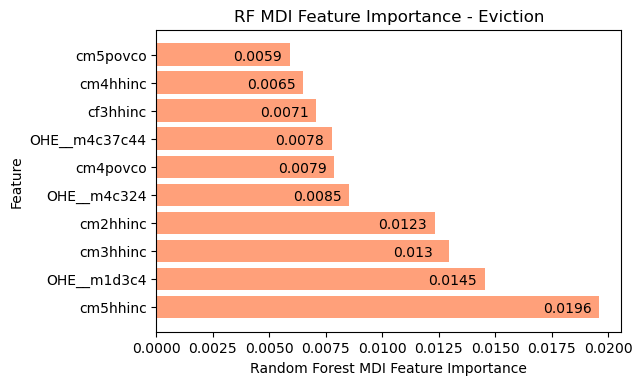

In [ ]:
# Plot top 10 most important features
feature_importances_mdi = model.steps[1][1].feature_importances_
feature_names = get_col_names(model.steps[0][1])

# Save feature importances for later
gpa_FI = sorted(zip(feature_names, feature_importances_mdi))

f_i_m = [x for _, x in sorted(zip(feature_names, feature_importances_mdi), 
                              key=lambda pair: pair[1], reverse=True)]
f_n = [x for x, y in sorted(zip(feature_names, feature_importances_mdi), 
                            key=lambda pair: pair[1], reverse=True)]

fig, ax = plt.subplots(dpi=100)
ax.barh(f_n[:10], f_i_m[:10], color='lightsalmon')
for i, v in enumerate(f_i_m[:10]):
    ax.text(v-0.0025, i-0.2, str(np.round(v, 4)), color='black', fontweight='normal')
ax.set_xlabel('Random Forest MDI Feature Importance')
ax.set_title('RF MDI Feature Importance - Eviction')
ax.set_ylabel('Feature')
plt.show()

In [ ]:
# Group features
gpa_feature_mapping = {'m': 0,'f': 0,'p': 0,'k': 0,'h': 0,'t': 0,'other': 0}

for f, i in sorted(zip(feature_names, feature_importances_mdi)):
    categorise_vars(f, i, gpa_feature_mapping)
    
gpa_feature_mapping

{'m': 0.5524040654737465,
 'f': 0.3079623355907033,
 'p': 0.05121058169084379,
 'k': 0.013586729840961464,
 'h': 0.0034993171001862513,
 't': 0.002282109297511651,
 'other': 0.06905486100604659}

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_trans)
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train_trans.iloc[i],
                feature_names=X_train_trans.columns)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_trans)
i = 6
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train_trans.iloc[i],
                feature_names=X_train_trans.columns)

#### XGBoost

In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=XGBRegressor())

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.04003570983441085
The MSE on the TEST data is 0.4054470347283157


----

### materialHardship

In [ ]:
# Prepare data
train_X, train_y, CV_X, CV_y, test_X, test_y = prepareData(response='materialHardship')

#### LASSO

In [ ]:
# Tune hyperparameters
params = {'model__alpha': [0.01, 0.05, 0.1, 0.15]}
best_params, best_score = tuneModel(model_type=Lasso(), params=params)
print(f"The best params are: {best_params}")
print(f"The best score is: {best_score}")

The best params are: {'model__alpha': 0.01}
The best score is: 0.1324787255884706


In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=Lasso(alpha=best_params['model__alpha']))

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.14268145859124526
The MSE on the TEST data is 0.021285098386673203


#### RandomForest

In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=RandomForestRegressor())

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.1848979745297642
The MSE on the TEST data is 0.020236966739109193


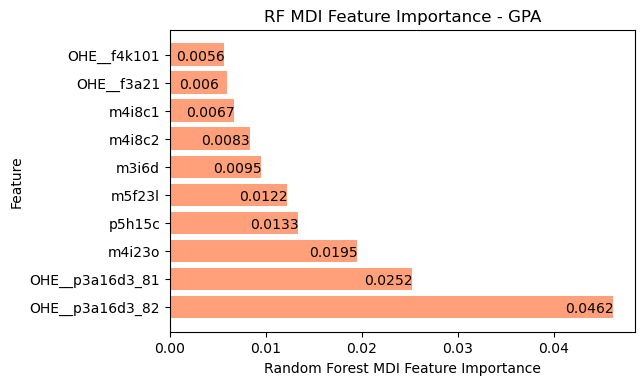

In [ ]:
# Plot top 10 most important features
feature_importances_mdi = model.steps[1][1].feature_importances_
feature_names = get_col_names(model.steps[0][1])

# Save feature importances for later
materialHardship_FI = sorted(zip(feature_names, feature_importances_mdi))

f_i_m = [x for _, x in sorted(zip(feature_names, feature_importances_mdi), 
                              key=lambda pair: pair[1], reverse=True)]
f_n = [x for x, y in sorted(zip(feature_names, feature_importances_mdi), 
                            key=lambda pair: pair[1], reverse=True)]

fig, ax = plt.subplots(dpi=100)
ax.barh(f_n[:10], f_i_m[:10], color='lightsalmon')
for i, v in enumerate(f_i_m[:10]):
    ax.text(v-0.005, i-0.2, str(np.round(v, 4)), color='black', fontweight='normal')
ax.set_xlabel('Random Forest MDI Feature Importance')
ax.set_title('RF MDI Feature Importance - materialHardship')
ax.set_ylabel('Feature')
plt.show()

In [ ]:
# Group features
materialHardship_feature_mapping = {'m': 0,'f': 0,'p': 0,'k': 0,'h': 0,'t': 0,'other': 0}

In [ ]:
for f, i in sorted(zip(feature_names, feature_importances_mdi)):
    categorise_vars(f, i, materialHardship_feature_mapping)

In [ ]:
materialHardship_feature_mapping

{'m': 0.4871114668132233,
 'f': 0.2917587143156039,
 'p': 0.14122153886220382,
 'k': 0.007943164748042455,
 'h': 0.003055030784997434,
 't': 0.002085825417321776,
 'other': 0.06682425905860735}

#### XGBoost

In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=XGBRegressor())

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.12654913778896737
The MSE on the TEST data is 0.02168562400101209


---

### Grit

In [ ]:
# Prepare data
train_X, train_y, CV_X, CV_y, test_X, test_y = prepareData(response='grit')

#### LASSO

In [ ]:
# Tune hyperparameters
params = {'model__alpha': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.5]}
best_params, best_score = tuneModel(model_type=Lasso(), params=params)
print(f"The best params are: {best_params}")
print(f"The best score is: {best_score}")

The best params are: {'model__alpha': 0.05}
The best score is: -0.0005036195036761005


In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=Lasso(alpha=best_params['model__alpha']))

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.004243010493398813
The MSE on the TEST data is 0.251850045931698


#### RandomForest

In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=RandomForestRegressor())

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is 0.03886860292309502
The MSE on the TEST data is 0.24309243023255814


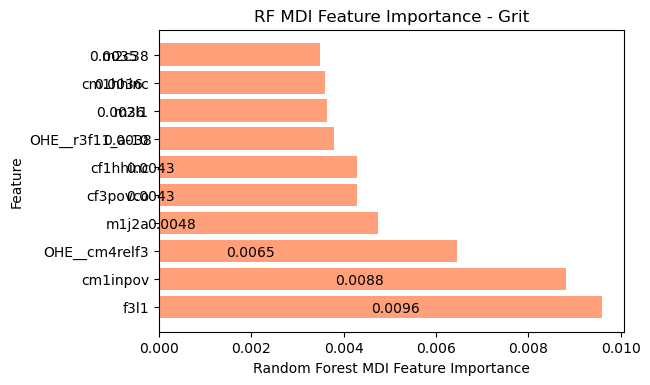

In [ ]:
# Plot top 10 most important features
feature_importances_mdi = model.steps[1][1].feature_importances_
feature_names = get_col_names(model.steps[0][1])

# Save feature importances for later
grit_FI = sorted(zip(feature_names, feature_importances_mdi))

f_i_m = [x for _, x in sorted(zip(feature_names, feature_importances_mdi), 
                              key=lambda pair: pair[1], reverse=True)]
f_n = [x for x, y in sorted(zip(feature_names, feature_importances_mdi), 
                            key=lambda pair: pair[1], reverse=True)]

fig, ax = plt.subplots(dpi=100)
ax.barh(f_n[:10], f_i_m[:10], color='lightsalmon')
for i, v in enumerate(f_i_m[:10]):
    ax.text(v-0.005, i-0.2, str(np.round(v, 4)), color='black', fontweight='normal')
ax.set_xlabel('Random Forest MDI Feature Importance')
ax.set_title('RF MDI Feature Importance - Grit')
ax.set_ylabel('Feature')
plt.show()

In [ ]:
# Group features
grit_feature_mapping = {'m': 0,'f': 0,'p': 0,'k': 0,'h': 0,'t': 0,'other': 0}

In [ ]:
for f, i in sorted(zip(feature_names, feature_importances_mdi)):
    categorise_vars(f, i, grit_feature_mapping)

In [ ]:
grit_feature_mapping

{'m': 0.46931310304951257,
 'f': 0.37455929874082516,
 'p': 0.04789683083998924,
 'k': 0.012492084691468378,
 'h': 0.0040086526099235385,
 't': 0.002668338773168743,
 'other': 0.08906169129511343}

#### XGBoost

In [ ]:
# Evaluate best model
r2, mse, model, y_pred = evaluateModel(model_with_params=XGBRegressor())

print(f"The R2 on the TEST data is {r2}")
print(f"The MSE on the TEST data is {mse}")

The R2 on the TEST data is -0.13826307735149457
The MSE on the TEST data is 0.2878931419355399


---

In [ ]:
# With response variable transformation

quantile = QuantileTransformer(n_quantiles=100, output_distribution='normal')
train_y_trans = [i[0] for i in quantile.fit_transform(train_y.values.reshape(-1, 1))]

# Create preprocessing and modelling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=best_param_))])

model = pipeline.fit(train_X, train_y_trans)
y_pred = model.predict(test_X)
r2 = r2_score(test_y, y_pred)
print(f"The R2 on the TEST data for GPA with a Lasso model is {r2}")

## Classification

### Prepare data

In [ ]:
# Replace True/False with 1/0
for col in ['eviction', 'layoff', 'jobTraining']:
    test[col] = test[col].apply(lambda x: 1 if x==True else (0 if x==False else np.NaN))

The main problem here is that we've got very imbalanced data.

In [ ]:
def prepareClassificationData(response):
    """Prepares data for modelling.
    """
    # Create copies of the data
    train_X = X_train.copy()
    train_y = y_train.copy()
    CV_X = X_CV.copy()
    CV_y = y_CV.copy()
    
    # Drop instances where the response is NaN
    train_y = train_y[response].dropna()
    train_X = train_X.loc[train_y.index.values]
    CV_y = CV_y[response].dropna()
    CV_X = CV_X.loc[CV_y.index.values]
    test_y = test[response].dropna()
    test_X = background.loc[test_y.index.values]
    
    return train_X, train_y, CV_X, CV_y, test_X, test_y

In [ ]:
def upsample(X, y):
    """Upsamples from the minority class, returning an evenly balanced data set.
    """
    
    # Identify the indices of the positive and negative samples

    positive_y_values = y[y==1]
    positive_X_rows = X.loc[y[y==1].index.values]

    negative_y_values = y[y==0]
    negative_X_rows = X.loc[y[y==0].index.values]

    # Upsample from the positive samples

    choices = np.random.choice(positive_y_values.index.values, 
                               (len(X)-len(positive_X_rows)))
    upsampled_positive_X_rows = positive_X_rows.loc[choices]
    upsampled_positive_y_values = positive_y_values[choices]

    # Join the new, evenly balanced data sets
    resampled_X_rows = pd.concat([negative_X_rows, upsampled_positive_X_rows], 
                                 axis=0).reset_index(drop=True)
    resampled_y_values = pd.concat([negative_y_values, upsampled_positive_y_values], 
                                   axis=0).reset_index(drop=True)
    
    # Concat and shuffle
    upsampled_df = pd.concat([resampled_X_rows, resampled_y_values], axis=1).sample(frac=1)
    
    X = upsampled_df.iloc[:, :-1]
    y = upsampled_df.iloc[:, -1]
    
    return X, y

In [ ]:
def downsample(X, y):
    """Downsamples from the majority class, returning an evenly balanced data set.
    """
    
    positive_y = y[y==1]
    negative_y = y[y==0].sample(len(positive_y))
    positive_X = X.loc[positive_y.index.values]
    negative_X = X.loc[negative_y.index.values]
    
    new_X = pd.concat([positive_X, negative_X], axis=0)
    new_y = pd.concat([positive_y, negative_y], axis=0)
    
    downsampled_df = pd.concat([new_X, new_y], axis=1).sample(frac=1)
    
    y = downsampled_df.iloc[:, -1]
    X = downsampled_df.iloc[:, :-1]
    
    return X, y

In [ ]:
def tuneClassifier(prepro=preprocessor, model_type=None, params=None):
    """Tunes a model to find the optimal hyperparameters.
    """
    
    pipeline = Pipeline(steps=[
        ('preprocessor', prepro),
        ('model', model_type)
    ])
    
    search = GridSearchCV(pipeline, params) # Use default 5-fold CV strategy
    model = search.fit(train_X, train_y)
    return model.best_params_, model.best_score_


def evaluateClassifier(prepro=preprocessor, model_with_params=None):
    """Fits a model using a given set of parameters (obtained from tuning, in previous
       step) to the train data and evaluates it on the test data.
    """
    
    pipeline = Pipeline(steps=[
        ('preprocessor', prepro),
        ('model', model_with_params)
    ])    
    
    model = pipeline.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    f1 = f1_score(test_y, y_pred, average='macro')
    auc = roc_auc_score(test_y, y_pred)
    return f1, auc, model, y_pred

---

### Eviction

In [ ]:
# Prepare data
train_X, train_y, CV_X, CV_y, test_X, test_y = prepareClassificationData('eviction')

# train_X, train_y = upsample(train_X, train_y)
# CV_X, CV_y = upsample(CV_X, CV_y)
# test_X, test_y = upsample(test_X, test_y)

train_X, train_y = downsample(train_X, train_y)
CV_X, CV_y = downsample(CV_X, CV_y)
test_X, test_y = downsample(test_X, test_y)

#### LASSO Logistic

In [ ]:
# Tune model

# Specify parameters
solvers = ['lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
params = {'model__solver':solvers, 'model__C':c_values}

# Tune model
best_params, best_score = tuneClassifier(model_type=LogisticRegression(), 
                                         params=params)

In [ ]:
print(f"The best params are: {best_params}")
print(f"The best score is: {best_score}")

The best params are: {'model__C': 10, 'model__solver': 'liblinear'}
The best score is: 0.5966666666666666


In [ ]:
# Evaluate model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=LogisticRegression(penalty='l1',
                                                                                 solver='liblinear',
                                                                                 C=10))

print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5756928372203429
The AUC on the TEST data is 0.5769230769230769


In [ ]:
brier_score_loss(y_pred, test_y)

0.4230769230769231

#### RandomForestClassifier

In [ ]:
# Evaluate model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=RandomForestClassifier())
print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5521501544309813
The AUC on the TEST data is 0.5538461538461539


In [ ]:
brier_score_loss(y_pred, test_y)

0.4461538461538462

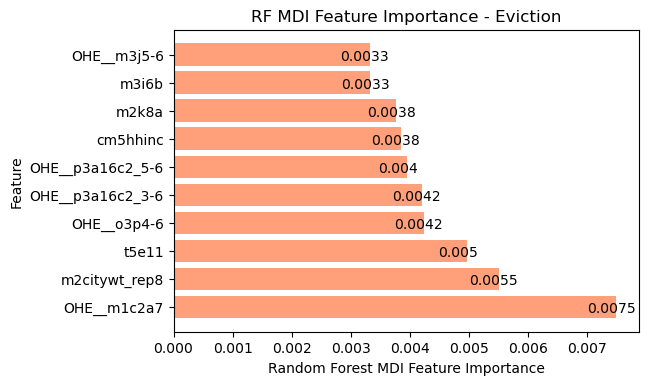

In [ ]:
# Plot top 10 most important features
feature_importances_mdi = model.steps[1][1].feature_importances_
feature_names = get_col_names(model.steps[0][1])

# Save feature importances for later
grit_FI = sorted(zip(feature_names, feature_importances_mdi))

f_i_m = [x for _, x in sorted(zip(feature_names, feature_importances_mdi), 
                              key=lambda pair: pair[1], reverse=True)]
f_n = [x for x, y in sorted(zip(feature_names, feature_importances_mdi), 
                            key=lambda pair: pair[1], reverse=True)]

fig, ax = plt.subplots(dpi=100)
ax.barh(f_n[:10], f_i_m[:10], color='lightsalmon')
for i, v in enumerate(f_i_m[:10]):
    ax.text(v-0.0005, i-0.2, str(np.round(v, 4)), color='black', fontweight='normal')
ax.set_xlabel('Random Forest MDI Feature Importance')
ax.set_title('RF MDI Feature Importance - Eviction')
ax.set_ylabel('Feature')
plt.show()

In [ ]:
# Group features
eviction_feature_mapping = {'m': 0,'f': 0,'p': 0,'k': 0,'h': 0,'t': 0,'other': 0}

for f, i in sorted(zip(feature_names, feature_importances_mdi)):
    categorise_vars(f, i, eviction_feature_mapping)
    
eviction_feature_mapping

{'m': 0.485350075728719,
 'f': 0.3358152247697708,
 'p': 0.07073167387391976,
 'k': 0.003453651975127238,
 'h': 0.0026369222228562967,
 't': 0.006936697856176923,
 'other': 0.09507575357342987}

#### XGBoost

In [ ]:
# Evaluate best model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=XGBClassifier())

print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.6533333333333333
The AUC on the TEST data is 0.6538461538461539


In [ ]:
brier_score_loss(y_pred, test_y)

0.34615384615384615

---

### jobTraining

In [ ]:
# Prepare data
train_X, train_y, CV_X, CV_y, test_X, test_y = prepareClassificationData('jobTraining')

# train_X, train_y = upsample(train_X, train_y)
# CV_X, CV_y = upsample(CV_X, CV_y)
# test_X, test_y = upsample(test_X, test_y)

train_X, train_y = downsample(train_X, train_y)
CV_X, CV_y = downsample(CV_X, CV_y)
test_X, test_y = downsample(test_X, test_y)

#### LASSO Logistic

In [ ]:
# Tune model

# Specify parameters
solvers = ['lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
params = {'model__solver':solvers, 'model__C':c_values}

# Tune model
best_params, best_score = tuneClassifier(model_type=LogisticRegression(), 
                                         params=params)

In [ ]:
print(f"The best params are: {best_params}")
print(f"The best score is: {best_score}")

The best params are: {'model__C': 10, 'model__solver': 'lbfgs'}
The best score is: 0.5692763157894737


In [ ]:
# Evaluate model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=LogisticRegression(solver='lbfgs',
                                                                                 C=10))

In [ ]:
print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5511088843672355
The AUC on the TEST data is 0.5516605166051661


In [ ]:
brier_score_loss(y_pred, test_y)

0.4483394833948339

#### RandomForest

In [ ]:
# Evaluate model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=RandomForestClassifier())
print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5774548153292549
The AUC on the TEST data is 0.5774907749077491


In [ ]:
brier_score_loss(y_pred, test_y)

0.4225092250922509

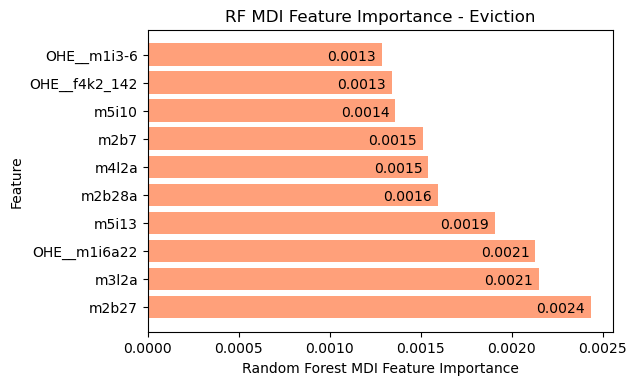

In [ ]:
# Plot top 10 most important features
feature_importances_mdi = model.steps[1][1].feature_importances_
feature_names = get_col_names(model.steps[0][1])

# Save feature importances for later
jobTraining_FI = sorted(zip(feature_names, feature_importances_mdi))

f_i_m = [x for _, x in sorted(zip(feature_names, feature_importances_mdi), 
                              key=lambda pair: pair[1], reverse=True)]
f_n = [x for x, y in sorted(zip(feature_names, feature_importances_mdi), 
                            key=lambda pair: pair[1], reverse=True)]

fig, ax = plt.subplots(dpi=100)
ax.barh(f_n[:10], f_i_m[:10], color='lightsalmon')
for i, v in enumerate(f_i_m[:10]):
    ax.text(v-0.0003, i-0.2, str(np.round(v, 4)), color='black', fontweight='normal')
ax.set_xlabel('Random Forest MDI Feature Importance')
ax.set_title('RF MDI Feature Importance - Eviction')
ax.set_ylabel('Feature')
plt.show()

In [ ]:
# Group features
jobTraining_feature_mapping = {'m': 0,'f': 0,'p': 0,'k': 0,'h': 0,'t': 0,'other': 0}

for f, i in sorted(zip(feature_names, feature_importances_mdi)):
    categorise_vars(f, i, jobTraining_feature_mapping)
    
jobTraining_feature_mapping

{'m': 0.4370663599199354,
 'f': 0.38877503016177617,
 'p': 0.05888730052385618,
 'k': 0.00753531601118694,
 'h': 0.00433227553741384,
 't': 0.0027321619450303286,
 'other': 0.10067155590080017}

In [ ]:
# Evaluate best model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=XGBClassifier())

print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5996187298939593
The AUC on the TEST data is 0.5996309963099631


In [ ]:
brier_score_loss(y_pred, test_y)

0.4003690036900369

---

### Layoff

In [ ]:
# Prepare data
train_X, train_y, CV_X, CV_y, test_X, test_y = prepareClassificationData('layoff')

# train_X, train_y = upsample(train_X, train_y)
# CV_X, CV_y = upsample(CV_X, CV_y)
# test_X, test_y = upsample(test_X, test_y)

train_X, train_y = downsample(train_X, train_y)
CV_X, CV_y = downsample(CV_X, CV_y)
test_X, test_y = downsample(test_X, test_y)

#### LASSO Logistic

In [ ]:
# Tune model

# Specify parameters
solvers = ['lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
params = {'model__solver':solvers, 'model__C':c_values}

# Tune model
best_params, best_score = tuneClassifier(model_type=LogisticRegression(), 
                                         params=params)

In [ ]:
print(f"The best params are: {best_params}")
print(f"The best score is: {best_score}")

The best params are: {'model__C': 100, 'model__solver': 'lbfgs'}
The best score is: 0.48012072434607644


In [ ]:
# Evaluate model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=LogisticRegression(solver='lbfgs',
                                                                                 C=100))

In [ ]:
print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5166748475257132
The AUC on the TEST data is 0.518957345971564


In [ ]:
brier_score_loss(y_pred, test_y)

0.48104265402843605

#### RandomForest

In [ ]:
# Evaluate model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=RandomForestClassifier())
print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5283062319206898
The AUC on the TEST data is 0.5284360189573459


In [ ]:
brier_score_loss(y_pred, test_y)

0.471563981042654

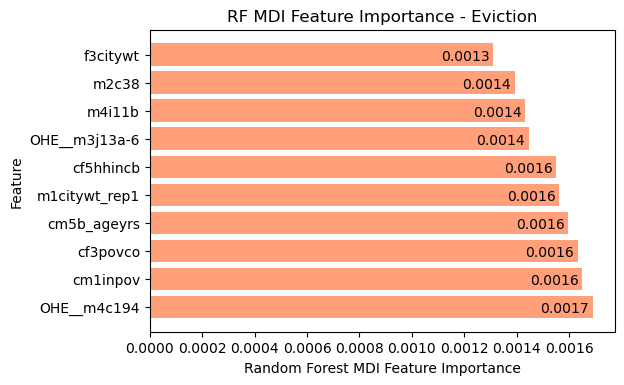

In [ ]:
# Plot top 10 most important features
feature_importances_mdi = model.steps[1][1].feature_importances_
feature_names = get_col_names(model.steps[0][1])

# Save feature importances for later
layoff_FI = sorted(zip(feature_names, feature_importances_mdi))

f_i_m = [x for _, x in sorted(zip(feature_names, feature_importances_mdi), 
                              key=lambda pair: pair[1], reverse=True)]
f_n = [x for x, y in sorted(zip(feature_names, feature_importances_mdi), 
                            key=lambda pair: pair[1], reverse=True)]

fig, ax = plt.subplots(dpi=100)
ax.barh(f_n[:10], f_i_m[:10], color='lightsalmon')
for i, v in enumerate(f_i_m[:10]):
    ax.text(v-0.0002, i-0.2, str(np.round(v, 4)), color='black', fontweight='normal')
ax.set_xlabel('Random Forest MDI Feature Importance')
ax.set_title('RF MDI Feature Importance - Eviction')
ax.set_ylabel('Feature')
plt.show()

In [ ]:
# Group features
layoff_feature_mapping = {'m': 0,'f': 0,'p': 0,'k': 0,'h': 0,'t': 0,'other': 0}

for f, i in sorted(zip(feature_names, feature_importances_mdi)):
    categorise_vars(f, i, layoff_feature_mapping)
    
layoff_feature_mapping

{'m': 0.43712811200965834,
 'f': 0.38807323898780866,
 'p': 0.04951740566926755,
 'k': 0.004847922536335025,
 'h': 0.0050576695257119495,
 't': 0.002756498245545983,
 'other': 0.11261915302567115}

#### XGBoost

In [ ]:
# Evaluate best model
f1, auc, model, y_pred = evaluateClassifier(model_with_params=XGBClassifier())

print(f"The F1-score on the TEST data is {f1}")
print(f"The AUC on the TEST data is {auc}")

The F1-score on the TEST data is 0.5543422087405909
The AUC on the TEST data is 0.5545023696682465


In [ ]:
brier_score_loss(y_pred, test_y)

0.44549763033175355

# Feature importances

In [ ]:
feature_importances_all = {'Layoff': layoff_feature_mapping,
                           'Grit': grit_feature_mapping,
                           'Eviction': eviction_feature_mapping,
                           'Job Training': jobTraining_feature_mapping,
                           'GPA': gpa_feature_mapping,
                           'Material Hardship': materialHardship_feature_mapping}

In [ ]:
# Reshape into df, ready for plotting
df = pd.DataFrame(feature_importances_all)
df = df.stack().to_frame()
df = df.reset_index(level=0).reset_index(level=0)
df.rename(columns={0: 'value', 'index': 'outcome', 'level_0': 'data source'}, inplace=True)

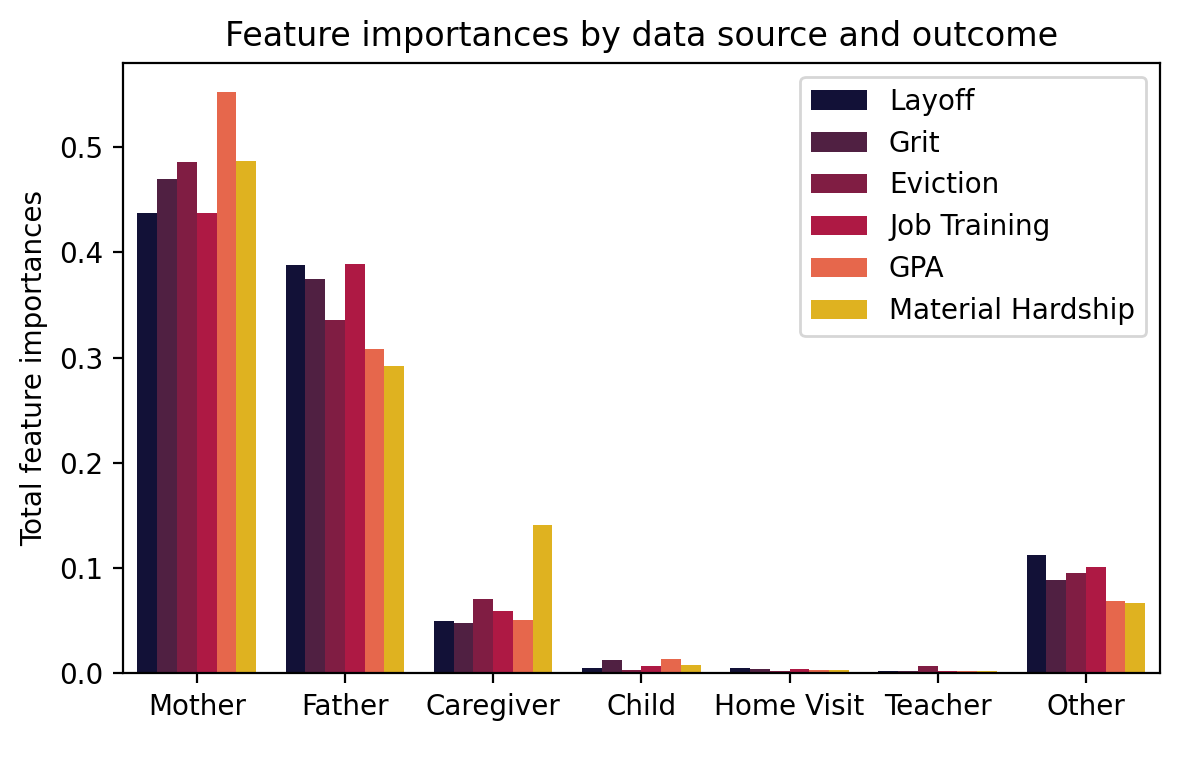

In [ ]:
fig, ax = plt.subplots(dpi=200)

palette = {
    'Layoff':'#0C0A3E',
    'Grit': '#581845',
    'Eviction': '#900C3F',
    'Job Training': '#C70039',
    'GPA': '#FF5733', 
    'Material Hardship': '#FFC300',
}

ax = sns.barplot(data=df, x='data source', y='value', hue='outcome', palette=palette)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total feature importances')
ax.set_xlabel(' ')
ax.set_title('Feature importances by data source and outcome')
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()

plt.show()